## The purpose of this homework is to implement Canny Edge Detector

In [0]:
import numpy as np
import matplotlib.pyplot as plt
# %matplotlib notebook

from skimage.io import imread
from skimage.transform import resize
from scipy.ndimage.filters import gaussian_filter
from tqdm import tqdm

In [0]:
from skimage.color import rgb2gray
from scipy.signal import convolve2d
from scipy import ndimage
import cv2

### As you know from theory, Canny Edge Detection algorithm is composed of 4 steps: 
- Bluring the image to suppress the noise
- Calculation of the gradient and the magnitude of the image-gradient
- Non-maximum suppression
- Hystersis thresholding

#### At first let's read and visualize an image.

In [0]:
img = imread('tree.jpg')/255.
img = resize(img, (240, 320), preserve_range=True)
img = rgb2gray(img)

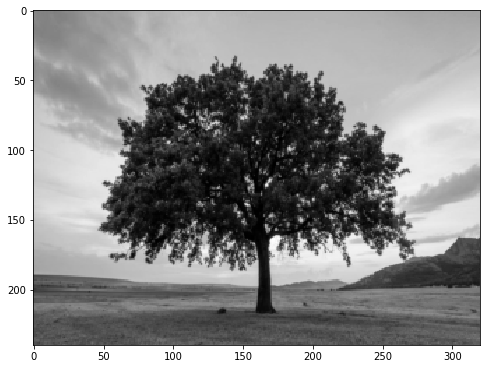

In [4]:
plt.figure(figsize=(8,8))
plt.imshow(img, cmap = 'gray')
plt.show()

In order to suppress the noise in the image, we apply bluring.

### Step 1: Gaussian blur

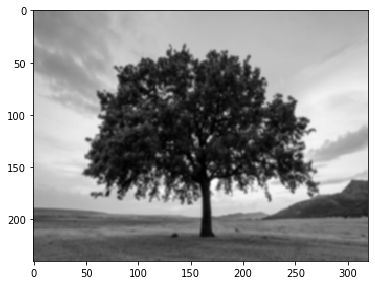

In [18]:
kernel = np.ones((3,3), np.float32)/9
# smooth_img = cv2.filter2D(img, -1, kernel)
smooth_img = cv2.GaussianBlur(img, (3,3), 1)
plt.figure(figsize=(6, 6))
plt.imshow(smooth_img, cmap = 'gray')
plt.show()

### Step 2: Gradient Calculation

In [0]:
# G_x, G_y = ndimage.sobel(img,axis=0,mode='constant'), ndimage.sobel(img,axis=1,mode='constant')# TODO Calculate the gradient of the image
Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)

G_x = convolve2d(img, Kx[::-1,::-1], mode='same')
G_y = convolve2d(img, Ky[::-1,::-1], mode='same')
M = np.hypot(G_x, G_y) # TODO Compute the magnitude of the image gradient
M = M/M.max()

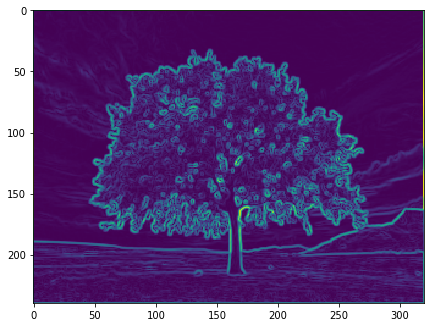

In [20]:
plt.figure(figsize=(7, 7))
plt.imshow(M)
plt.show()

### Step 3: Non-Maximum Suppression

#### Note !!! for implementation of non-maximum suppression you can follow the following steps, but your own implementation is also applicable.

Defining four directions

In [0]:
d_x = (1, 1/np.sqrt(2), 0, 1/np.sqrt(2))
d_y = (0, 1/np.sqrt(2), 1, -1/np.sqrt(2))
D = np.array([[d_x[i], d_y[i]] for i in range(4)])

In [0]:
delta_direction = {0: (1, 0), 1: (1, 1), 2: (0, 1), 3: (1, -1)}

In [0]:
from scipy.spatial import distance
import numpy.linalg as la

In [0]:
def get_closest_direction(D, pixel):
    dst = np.zeros(shape=(4,1))
    for i, direction in enumerate(D):
        dst[i] = np.dot(pixel, direction) / (la.norm(pixel) * la.norm(direction))
    return np.argmax(dst, axis=0)[0]

In [0]:
A = np.zeros(shape = img.shape)
for i in range(img.shape[0]):
    for j in range(img.shape[1]):
        A[i, j] = get_closest_direction(D, np.array([G_x[i, j], G_y[i, j]]))
# TODO Obtain a matrix of shape (img.shape[0], img.shape[1]), 
# for which A[i,j] is the number of the closest direction from D in the point (i,j). 
# For example, if the direction D[1,:] is the closest to the gradient of the image in the point (i,j), 
# i.e. G[i,j,:], then A[i,j] = 1.

In [0]:
A

array([[3., 3., 3., ..., 3., 3., 3.],
       [0., 3., 3., ..., 3., 3., 2.],
       [0., 3., 3., ..., 3., 3., 2.],
       ...,
       [0., 2., 2., ..., 2., 2., 2.],
       [0., 2., 2., ..., 3., 3., 2.],
       [1., 2., 2., ..., 2., 2., 2.]])

In [0]:
res = np.zeros((img.shape[0], img.shape[1]))
M_pad = np.zeros((img.shape[0]+2, img.shape[1]+2))
M_pad[1:-1,1:-1] = M.copy()
for i in tqdm(range(img.shape[0])):
    for j in range(img.shape[1]):
        direction1 = delta_direction[int(A[i, j])] #np.rint(D[int(A[i, j])])
            
        M_p = M_pad[i + int(direction1[0]) + 1, j + int(direction1[1]) + 1]
        M_n = M_pad[i - int(direction1[0]) + 1, j - int(direction1[1]) + 1]

        if M_pad[i + 1,j + 1] >= M_p and M_pad[i + 1,j + 1] >= M_n:
            res[i,j] = M_pad[i + 1,j + 1]


100%|███████████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 478.54it/s]


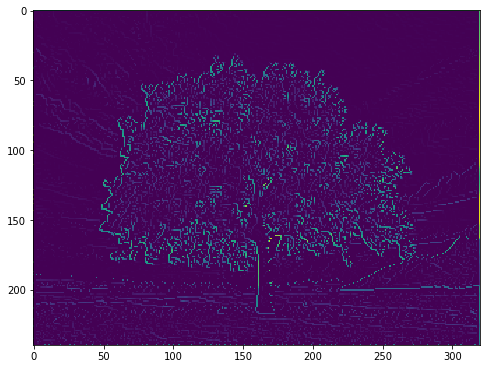

In [0]:
plt.figure(figsize=(8, 8))
plt.imshow(res)

### Step 4: Hystersis Thresholding

In [0]:
def hyst(img, t_h, t_l):
    
    M_h = np.zeros(shape=img.shape)
    M_l = np.zeros(shape=img.shape)
    res = np.zeros(shape=img.shape)
    
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if img[i, j] >= t_h:
                M_h[i, j] = 1
            elif img[i, j] >= t_l:
                M_l[i, j] = 1
    
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if M_h[i, j] == 1:
                res[i, j] = 1
            elif M_l[i, j] == 1:
                try:
                    if ((M_h[i+1, j-1] == 1) or (M_h[i+1, j] == 1) or (M_h[i+1, j+1] == 1)
                        or (M_h[i, j-1] == 1) or (M_h[i, j+1] == 1)
                        or (M_h[i-1, j-1] == 1) or (M_h[i-1, j] == 1) or (M_h[i-1, j+1] == 1)):
                        res[i, j] = 1
                except IndexError as e:
                    pass
            
            
    # TODO Implement the hystersis thresholding with high threshold t_h, low threshold t_l
    return res

In [0]:
can_res = hyst(res, 0.2, 0.05)

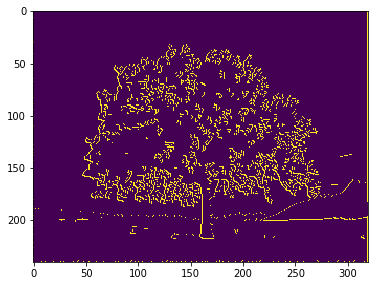

In [0]:
plt.figure(figsize=(6, 6))
plt.imshow(can_res)